# Block Encoding

High level bloqs for defining bloq encodings and operations on block encodings.

Given an operator $V$ which can be expressed as a linear combination of unitaries

$$
    V = \sum_l^L w_l U_l,
$$
where $w_l \ge 0$, $w_l \in \mathbb{R}$, and $U_l$ is a unitary, then the block
encoding $\mathcal{B}\left[\frac{V}{\lambda}\right]$ satisifies
$$
    _a\langle 0| \mathcal{B}\left[\frac{V}{\lambda}\right] |0\rangle_a
    |\psi\rangle_s = \frac{V}{\lambda}|\psi\rangle_s
$$
where the subscripts $a$ and $s$ signify ancilla and system registers
respectively, and $\lambda = \sum_l w_l$. The ancilla register is at least of size $\log L$. In our
implementations we typically split the ancilla registers into selection registers (i.e.
the $l$ registers above) and junk registers which are extra qubits needed by
state preparation but not controlled upon during SELECT.

In [1]:
from qualtran import Bloq, CompositeBloq, BloqBuilder, Signature, Register
from qualtran import QBit, QInt, QUInt, QAny
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma
from typing import *
import numpy as np
import sympy
import cirq

## `BlackBoxBlockEncoding`
Black box implementation of a block encoding using SELECT and PREPARE.

Builds the block encoding via
$$
    \mathcal{B}[V] = \mathrm{PREPARE}^\dagger \cdot \mathrm{SELECT} \cdot \mathrm{PREPARE},
$$
where
$$
    \mathrm{PREPARE} |0\rangle_a = \sum_l \sqrt{\frac{w_l}{\lambda}} |l\rangle_a,
$$
and
$$
    \mathrm{SELECT} |l\rangle_a|\psi\rangle_s = |l\rangle_a U_l |\psi\rangle_s.
$$

#### Parameters
 - `select`: The bloq implementing the `SelectOracle` interface.
 - `prepare`: The bloq implementing the `SelectOracle` interface. 

#### Registers
 - `selection`: The combined selection register.
 - `junk`: Additional junk registers not prepared upon.
 - `system`: The combined system register.


In [2]:
from qualtran.bloqs.block_encoding import BlackBoxBlockEncoding

### Example Instances

In [3]:
from qualtran.bloqs.block_encoding import BlackBoxBlockEncoding, BlackBoxPrepare, BlackBoxSelect
from qualtran.bloqs.hubbard_model import PrepareHubbard, SelectHubbard

dim = 3
select = BlackBoxSelect(SelectHubbard(x_dim=dim, y_dim=dim))
prepare = BlackBoxPrepare(PrepareHubbard(x_dim=dim, y_dim=dim, t=1, mu=4))
black_box_block_bloq = BlackBoxBlockEncoding(select=select, prepare=prepare)

#### Graphical Signature

In [4]:
from qualtran.drawing import show_bloqs
show_bloqs([black_box_block_bloq],
           ['`black_box_block_bloq`'])

### Call Graph

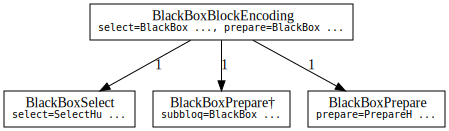

#### Counts totals:
 - `Adjoint(subbloq=BlackBoxPrepare(prepare=PrepareHubbard(x_dim=3, y_dim=3, t=1, mu=4)))`: 1
 - `BlackBoxPrepare(prepare=PrepareHubbard(x_dim=3, y_dim=3, t=1, mu=4))`: 1
 - `BlackBoxSelect(select=SelectHubbard(x_dim=3, y_dim=3, control_val=None))`: 1

In [5]:
from qualtran.resource_counting.generalizers import ignore_split_join
black_box_block_bloq_g, black_box_block_bloq_sigma = black_box_block_bloq.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(black_box_block_bloq_g)
show_counts_sigma(black_box_block_bloq_sigma)

## `ChebyshevPolynomial`
Block encoding of $T_j[H]$ where $T_j$ is the $j$-th Chebyshev polynomial.

Here H is a Hamiltonian with spectral norm $|H| \le 1$, we assume we have
an $n_L$ qubit ancilla register, and assume that $j > 0$ to avoid block
encoding the identity operator.

Recall:

\begin{align*}
    T_0[H] &= \mathbb{1} \\
    T_1[H] &= H \\
    T_2[H] &= 2 H^2 - \mathbb{1} \\
    T_3[H] &= 4 H^3 - 3 H \\
    &\dots
\end{align*}

#### Parameters
 - `block_encoding`: Block encoding of a Hamiltonian $H$, $\mathcal{B}[H]$.
 - `order`: order of Chebychev polynomial. 

#### References
 - [Quantum computing enhanced computational catalysis](     https://arxiv.org/abs/2007.14460). Page 45; Theorem 1.


In [6]:
from qualtran.bloqs.block_encoding import ChebyshevPolynomial

### Example Instances

In [7]:
from qualtran.bloqs.block_encoding import BlackBoxBlockEncoding, BlackBoxPrepare, BlackBoxSelect
from qualtran.bloqs.hubbard_model import PrepareHubbard, SelectHubbard

dim = 3
select = BlackBoxSelect(SelectHubbard(x_dim=dim, y_dim=dim))
prepare = BlackBoxPrepare(PrepareHubbard(x_dim=dim, y_dim=dim, t=1, mu=4))
black_box_block_bloq = BlackBoxBlockEncoding(select=select, prepare=prepare)
chebyshev_poly = ChebyshevPolynomial(black_box_block_bloq, order=3)

#### Graphical Signature

In [8]:
from qualtran.drawing import show_bloqs
show_bloqs([chebyshev_poly],
           ['`chebyshev_poly`'])

### Call Graph

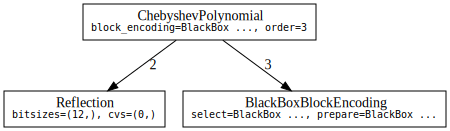

#### Counts totals:
 - `BlackBoxBlockEncoding(select=BlackBoxSelect(select=SelectHubbard(x_dim=3, y_dim=3, control_val=None)), prepare=BlackBoxPrepare(prepare=PrepareHubbard(x_dim=3, y_dim=3, t=1, mu=4)))`: 3
 - `Reflection(bitsizes=(12,), cvs=(0,))`: 2

In [9]:
from qualtran.resource_counting.generalizers import ignore_split_join
chebyshev_poly_g, chebyshev_poly_sigma = chebyshev_poly.call_graph(max_depth=1, generalizer=ignore_split_join)
show_call_graph(chebyshev_poly_g)
show_counts_sigma(chebyshev_poly_sigma)